# Kaggle - Natural Language Processing with Disaster Tweets
### Predict which Tweets are about real disasters and which ones are not
https://www.kaggle.com/competitions/nlp-getting-started/overview

In [392]:
import numpy as np
import pandas as pd
import tensorflow as tf
import transformers as ppb 
import matplotlib.pyplot as plt
import os
from tensorflow import keras
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.preprocessing import OneHotEncoder

In [393]:
# load data
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

In [394]:
print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [395]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [396]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


### Text

In [397]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


### Keyword

In [398]:
df_train.groupby(["keyword"]).describe()

id                                              \
                    count          mean        std      min       25%   
keyword                                                                 
ablaze               36.0     70.388889  14.035216     48.0     58.50   
accident             35.0    121.800000  15.118746     96.0    109.50   
aftershock           34.0    171.323529  13.975564    146.0    160.25   
airplane%20accident  35.0    220.142857  15.406536    196.0    208.50   
ambulance            38.0    269.052632  14.101845    246.0    258.50   
...                   ...           ...        ...      ...       ...   
wounded              37.0  10609.135135  14.491688  10585.0  10598.00   
wounds               33.0  10662.393939  14.225724  10636.0  10651.00   
wreck                37.0  10708.513514  15.230856  10685.0  10695.00   
wreckage             39.0  10759.717949  14.730828  10735.0  10747.50   
wrecked              39.0  10810.692308  15.178159  10785.0  10798.50   

                                                target            ...       \
                         50%       75%      max  count      mean  ...  75%   
keyword                                                           ...        
ablaze                  69.5     81.25     95.0   36.0  0.361111  ...  1.0   
accident               121.0    134.50    145.0   35.0  0.685714  ...  1.0   
aftershock             171.5    182.75    195.0   34.0  0.000000  ...  0.0   
airplane%20accident    219.0    233.50    245.0   35.0  0.857143  ...  1.0   
ambulance              268.5    279.75    294.0   38.0  0.526316  ...  1.0   
...                      ...       ...      ...    ...       ...  ...  ...   
wounded              10609.0  10622.00  10632.0   37.0  0.702703  ...  1.0   
wounds               10663.0  10675.00  10684.0   33.0  0.303030  ...  1.0   
wreck                10708.0  10722.00  10733.0   37.0  0.189189  ...  0.0   
wreckage             10760.0  10771.50  10784.0   39.0  1.000000  ...  1.0   
wrecked              10812.0  10823.50  10834.0   39.0  0.076923  ...  0.0   

                         length                                              \
                     max  count        mean        std   min     25%    50%   
keyword                                                                       
ablaze               1.0   36.0   94.694444  32.535536  22.0   74.50   95.5   
accident             1.0   35.0  100.085714  34.494135  35.0   73.00   97.0   
aftershock           0.0   34.0  101.205882  37.767855  27.0   69.75  112.0   
airplane%20accident  1.0   35.0  106.400000  30.154699  26.0   81.50  110.0   
ambulance            1.0   38.0   98.394737  22.902307  34.0   87.00  103.0   
...                  ...    ...         ...        ...   ...     ...    ...   
wounded              1.0   37.0  111.054054  29.959181  52.0   88.00  132.0   
wounds               1.0   33.0  103.363636  33.620881  18.0   80.00  114.0   
wreck                1.0   37.0   88.540541  35.934040  12.0   63.00   85.0   
wreckage             1.0   39.0  122.256410  24.763851  60.0  107.00  136.0   
wrecked              1.0   39.0   77.153846  32.106352  17.0   48.50   80.0   

                                   
                       75%    max  
keyword                            
ablaze               122.5  140.0  
accident             136.0  142.0  
aftershock           136.0  139.0  
airplane%20accident  136.0  140.0  
ambulance            110.0  138.0  
...                    ...    ...  
wounded              136.0  145.0  
wounds               133.0  146.0  
wreck                121.0  140.0  
wreckage             136.0  139.0  
wrecked              102.0  137.0  

[221 rows x 24 columns]

In [399]:
df_train.groupby(["keyword"])["keyword"].count()

keyword
ablaze                 36
accident               35
aftershock             34
airplane%20accident    35
ambulance              38
                       ..
wounded                37
wounds                 33
wreck                  37
wreckage               39
wrecked                39
Name: keyword, Length: 221, dtype: int64

In [400]:
df_test.groupby(["keyword"]).describe()

id                                                      \
                    count          mean        std      min      25%      50%   
keyword                                                                         
ablaze               14.0     70.785714  16.446550     46.0     58.5     71.0   
accident             15.0    117.466667  13.211827     99.0    107.0    116.0   
aftershock           16.0    168.750000  16.114176    147.0    153.5    168.0   
airplane%20accident  15.0    221.333333  12.893335    200.0    210.5    224.0   
ambulance            12.0    275.083333  15.733337    250.0    258.5    280.0   
...                   ...           ...        ...      ...      ...      ...   
wounded              13.0  10610.538462  15.365629  10586.0  10597.0  10614.0   
wounds               17.0  10653.882353  13.972662  10635.0  10643.0  10652.0   
wreck                13.0  10712.307692  12.658229  10694.0  10701.0  10714.0   
wreckage             11.0  10758.727273  14.690752  10738.0  10749.0  10758.0   
wrecked              11.0  10805.272727  11.858254  10791.0  10796.5  10804.0   

                                       length                               \
                          75%      max  count        mean        std   min   
keyword                                                                      
ablaze                  86.25     94.0   14.0   96.785714  36.597979  44.0   
accident               124.50    142.0   15.0  109.733333  29.339069  31.0   
aftershock             182.25    192.0   16.0  100.250000  39.250478  34.0   
airplane%20accident    231.50    239.0   15.0  113.466667  31.849796  56.0   
ambulance              286.50    295.0   12.0  103.166667  24.564695  76.0   
...                       ...      ...    ...         ...        ...   ...   
wounded              10619.00  10634.0   13.0  101.461538  34.216505  40.0   
wounds               10664.00  10683.0   17.0  104.470588  36.944414  11.0   
wreck                10719.00  10734.0   13.0   93.461538  41.508263  23.0   
wreckage             10767.50  10781.0   11.0  113.636364  30.342290  60.0   
wrecked              10811.50  10828.0   11.0   97.727273  34.928759  34.0   

                                                   
                        25%    50%     75%    max  
keyword                                            
ablaze                68.25  101.5  132.75  143.0  
accident              99.00  115.0  134.50  139.0  
aftershock            72.75  110.0  135.75  149.0  
airplane%20accident   84.00  130.0  135.00  147.0  
ambulance             81.75  100.5  116.75  141.0  
...                     ...    ...     ...    ...  
wounded               78.00   95.0  135.00  142.0  
wounds                88.00  113.0  136.00  142.0  
wreck                 57.00   95.0  136.00  146.0  
wreckage             101.00  135.0  136.00  137.0  
wrecked               76.00   94.0  123.50  143.0  

[221 rows x 16 columns]

In [401]:
df_train.groupby(["keyword", "target"])["keyword"].count()

keyword     target
ablaze      0         23
            1         13
accident    0         11
            1         24
aftershock  0         34
                      ..
wreck       0         30
            1          7
wreckage    1         39
wrecked     0         36
            1          3
Name: keyword, Length: 438, dtype: int64

### One-hot encoding keywords

In [402]:
# concat test and train dataframe
df_keywords = pd.concat([df_test["keyword"], df_train["keyword"]])

In [403]:
# Creating the One Hot Encoder 
oneHot = OneHotEncoder(categories='auto') 

oneHot.fit(df_keywords.values.reshape(-1,1)) 
train_keyword = oneHot.transform(df_train["keyword"].values.reshape(-1,1)).toarray()
test_keyword = oneHot.transform(df_test["keyword"].values.reshape(-1,1)).toarray()

In [404]:
print("shape of one-hot train keyword: ", train_keyword.shape)
print("shape of one-hot test keyword: ", test_keyword.shape)

shape of one-hot train keyword:  (7613, 222)
shape of one-hot test keyword:  (3263, 222)


### Location

In [405]:
df_train.groupby(["location"]).describe()

id                                                   \
                       count     mean std      min      25%      50%      75%   
location                                                                        
                         1.0   9703.0 NaN   9703.0   9703.0   9703.0   9703.0   
  Glasgow                1.0  10822.0 NaN  10822.0  10822.0  10822.0  10822.0   
  Melbourne, Australia   1.0   2579.0 NaN   2579.0   2579.0   2579.0   2579.0   
  News                   1.0   3955.0 NaN   3955.0   3955.0   3955.0   3955.0   
  å_                     1.0   5338.0 NaN   5338.0   5338.0   5338.0   5338.0   
...                      ...      ...  ..      ...      ...      ...      ...   
å_: ?? ÌÑ ? : ?          1.0   5918.0 NaN   5918.0   5918.0   5918.0   5918.0   
å_å_Los Mina Cityã¢     1.0   9788.0 NaN   9788.0   9788.0   9788.0   9788.0   
å¡å¡Midwest Û¢Û¢       1.0  10023.0 NaN  10023.0  10023.0  10023.0  10023.0   
åÊ(?Û¢`?Û¢å«)??        1.0  10293.0 NaN  10293.0  10293.0  10293.0  10293.0   
åø\_(?)_/åø              1.0   3478.0 NaN   3478.0   3478.0   3478.0   3478.0   

                                target       ...           length             \
                            max  count mean  ...  75%  max  count   mean std   
location                                     ...                               
                         9703.0    1.0  1.0  ...  1.0  1.0    1.0   56.0 NaN   
  Glasgow               10822.0    1.0  0.0  ...  0.0  0.0    1.0   70.0 NaN   
  Melbourne, Australia   2579.0    1.0  0.0  ...  0.0  0.0    1.0  131.0 NaN   
  News                   3955.0    1.0  1.0  ...  1.0  1.0    1.0  135.0 NaN   
  å_                     5338.0    1.0  0.0  ...  0.0  0.0    1.0   35.0 NaN   
...                         ...    ...  ...  ...  ...  ...    ...    ...  ..   
å_: ?? ÌÑ ? : ?          5918.0    1.0  0.0  ...  0.0  0.0    1.0   82.0 NaN   
å_å_Los Mina Cityã¢     9788.0    1.0  0.0  ...  0.0  0.0    1.0  136.0 NaN   
å¡å¡Midwest Û¢Û¢      10023.0    1.0  0.0  ...  0.0  0.0    1.0   52.0 NaN   
åÊ(?Û¢`?Û¢å«)??       10293.0    1.0  0.0  ...  0.0  0.0    1.0   33.0 NaN   
åø\_(?)_/åø              3478.0    1.0  1.0  ...  1.0  1.0    1.0  135.0 NaN   

                                                           
                          min    25%    50%    75%    max  
location                                                   
                         56.0   56.0   56.0   56.0   56.0  
  Glasgow                70.0   70.0   70.0   70.0   70.0  
  Melbourne, Australia  131.0  131.0  131.0  131.0  131.0  
  News                  135.0  135.0  135.0  135.0  135.0  
  å_                     35.0   35.0   35.0   35.0   35.0  
...                       ...    ...    ...    ...    ...  
å_: ?? ÌÑ ? : ?          82.0   82.0   82.0   82.0   82.0  
å_å_Los Mina Cityã¢    136.0  136.0  136.0  136.0  136.0  
å¡å¡Midwest Û¢Û¢       52.0   52.0   52.0   52.0   52.0  
åÊ(?Û¢`?Û¢å«)??        33.0   33.0   33.0   33.0   33.0  
åø\_(?)_/åø             135.0  135.0  135.0  135.0  135.0  

[3341 rows x 24 columns]

### Target

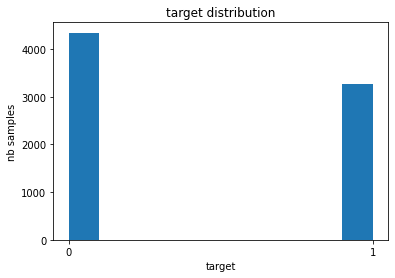

In [406]:
labels = df_train["target"]
plt.hist(labels)
plt.xlabel('target')
plt.ylabel('nb samples')
plt.title('target distribution')
plt.xticks(np.arange(len(np.unique(labels))));

### Loading the Pre-trained BERT model

In [407]:
model_class, tokenizer_class, pretrained_weights = (ppb.TFDistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_projector', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [408]:
model.summary()

Model: "tf_distil_bert_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  66362880  
Total params: 66,362,880
Trainable params: 66,362,880
Non-trainable params: 0
_________________________________________________________________


### Tokenization

In [409]:
def tokenize(sentences):
    tokenized = [tokenizer(sentence, add_special_tokens=True)['input_ids'] for sentence in sentences]
    return tokenized

In [410]:
tokenized = tokenize(df_train["text"])

In [411]:
print("sentence: ", df_train["text"][0] )
print("tokenized: ", tokenized[0])
print("decoded: ", tokenizer.decode(tokenized[0]))

sentence:  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
tokenized:  [101, 2256, 15616, 2024, 1996, 3114, 1997, 2023, 1001, 8372, 2089, 16455, 9641, 2149, 2035, 102]
decoded:  [CLS] our deeds are the reason of this # earthquake may allah forgive us all [SEP]


### Padding

In [412]:
# get the maxh length
max_len = max(df_train["length"].max(), df_test["length"].max())
print("Max sentence length is ", max_len)

Max sentence length is  157


In [413]:
def pad_tokens(tokens, max_len):
    padded = np.array([i + [0]*(max_len-len(i)) for i in tokens])
    return padded

In [414]:
padded = pad_tokens(tokenized, max_len)
print(padded[0])

[  101  2256 15616  2024  1996  3114  1997  2023  1001  8372  2089 16455
  9641  2149  2035   102     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0]


In [415]:
print("shape of padded: ", padded.shape)

shape of padded:  (7613, 157)


### Masking

In [416]:
def get_attention_mask(tokens):
    attention_mask = np.where(tokens != 0, 1, 0)    
    return attention_mask

In [417]:
attention_mask = get_attention_mask(padded)
print(attention_mask[0])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [418]:
print("shape of attention mask: ", attention_mask.shape)

shape of attention mask:  (7613, 157)


### Create input tensor

In [419]:
input_ids = tf.convert_to_tensor(padded, dtype=tf.int32)
attention_mask = tf.convert_to_tensor(attention_mask, dtype=tf.int32)

### Extract feature vectors
The model() function runs our sentences through BERT. The results of the processing will be returned into last_hidden_states.

In [420]:
def extract_features(input_ids, attention_mask):
    batch_size = 500
    m = input_ids.shape[0]
    n = int(m / batch_size)

    hidden_units =  model.config.to_dict()['dim']
    features = np.zeros((m, hidden_units))

    print('Extract features using batches for memory issue:')

    for i in range(n):
        j, k = i*batch_size, i*batch_size+batch_size
        print(f'Batch {i+1} [{j}:{k}]')
        batch_input = input_ids[j:k]
        batch_attention_mask = attention_mask[j:k]
        last_hidden_states = model(batch_input, attention_mask = batch_attention_mask)

        # Let's slice only the part of the output that we need. That is the output corresponding the first token of each sentence. 
        # The way BERT does sentence classification, is that it adds a token called [CLS] (for classification) at the beginning of 
        # every sentence. The output corresponding to that token can be thought of as an embedding for the entire sentence.
        features[j:k] = last_hidden_states[0][:,0,:].numpy()

        ## if you use BERT instead of distilBERT model, use this
        #features[j:k] = last_hidden_states[1].numpy() 

    if(n*batch_size != m):
        i = i + 1
        j, k = i*batch_size, i*batch_size+(m-n*batch_size)
        print(f'Batch {i+1} [{j}:{k}]')
        batch_input = input_ids[j:k]
        batch_attention_mask = attention_mask[j:k]
        last_hidden_states = model(batch_input, attention_mask = batch_attention_mask)
        features[j:k] = last_hidden_states[0][:,0,:].numpy()

    return features

In [421]:
def get_features(input_ids, attention_mask, filename):
    if os.path.exists(filename):
        F = np.load(filename)
    else:
        F = extract_features(input_ids, attention_mask)
        np.save(filename, F)
    return F

In [422]:
features = get_features(input_ids, attention_mask, "data/E_train.npy")
print("shape of feature vectors: ", features.shape)

shape of feature vectors:  (7613, 768)


### Extract Labels

In [423]:
lables = df_train["target"].to_numpy()
print("shape of feature labels: ", labels.shape)

shape of feature labels:  (7613,)


### Train/Validation split

In [732]:
# 80% train, 20% validation
split_size = int(features.shape[0] * .8)    
X_train = features[:split_size,:]
Y_train = lables[:split_size]
X_val = features[split_size:,:]
Y_val = lables[split_size:]

print("shapes of training data: ", X_train.shape, Y_train.shape)
print("shapes of validation data: ", X_val.shape, Y_val.shape)

shapes of training data:  (6090, 768) (6090,)
shapes of validation data:  (1523, 768) (1523,)


In [733]:
# append keyword
X_train = np.append(X_train, train_keyword[:split_size,:], axis=1)
X_val = np.append(X_val, train_keyword[split_size:,:], axis=1)

print("shapes of training data: ", X_train.shape, Y_train.shape)
print("shapes of validation data: ", X_val.shape, Y_val.shape)

shapes of training data:  (6090, 990) (6090,)
shapes of validation data:  (1523, 990) (1523,)


### Create the Logistic Regression Model

In [734]:
def create_model(input_shape, classes):
    inputs = keras.Input(shape=input_shape, name='input')
    h1 = keras.layers.Dense(2048, activation='sigmoid', name='h1')(inputs)    
    #d1 = keras.layers.Dropout(0.1, name='d1')(h1)
    h2 = keras.layers.Dense(512, activation='sigmoid', name='h2')(h1)
    #d2 = keras.layers.Dropout(0.1, name='d2')(h2)
    h3 = keras.layers.Dense(1024, activation='sigmoid', name='h3')(h2)
    #d4 = keras.layers.Dropout(0.1, name='d4')(h3)

    outputs = keras.layers.Dense(classes, activation='sigmoid', name='output')(h3)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    optimizer = tf.keras.optimizers.Adamax()

    model.compile(
        loss='binary_crossentropy', 
        optimizer=optimizer, 
        metrics=['binary_accuracy']
    )

    return model

In [735]:
lr_model = create_model(X_train.shape[1], 1)
lr_model.summary()

Model: "model_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 990)]             0         
_________________________________________________________________
h1 (Dense)                   (None, 2048)              2029568   
_________________________________________________________________
h2 (Dense)                   (None, 512)               1049088   
_________________________________________________________________
h3 (Dense)                   (None, 1024)              525312    
_________________________________________________________________
output (Dense)               (None, 1)                 1025      
Total params: 3,604,993
Trainable params: 3,604,993
Non-trainable params: 0
_________________________________________________________________


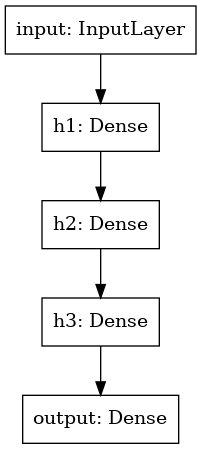

In [736]:
keras.utils.plot_model(lr_model)

### Train the model

In [737]:
history = lr_model.fit(
    X_train,
    Y_train,
    epochs=50,
    batch_size=128,
    validation_split=0.2,
    verbose=1
)

Epoch 1/50
22/39 [===============>..............] - ETA: 0s - loss: 0.7941 - binary_accuracy: 0.5479

39/39 [==============================] - 1s 28ms/step - loss: 0.7460 - binary_accuracy: 0.5593 - val_loss: 0.6765 - val_binary_accuracy: 0.5813
Epoch 2/50
39/39 [==============================] - 1s 23ms/step - loss: 0.6552 - binary_accuracy: 0.5915 - val_loss: 0.6188 - val_binary_accuracy: 0.5895
Epoch 3/50
39/39 [==============================] - 1s 24ms/step - loss: 0.5639 - binary_accuracy: 0.7373 - val_loss: 0.4935 - val_binary_accuracy: 0.7931
Epoch 4/50
39/39 [==============================] - 1s 27ms/step - loss: 0.4902 - binary_accuracy: 0.7736 - val_loss: 0.4531 - val_binary_accuracy: 0.8062
Epoch 5/50
39/39 [==============================] - 1s 23ms/step - loss: 0.4612 - binary_accuracy: 0.7861 - val_loss: 0.4511 - val_binary_accuracy: 0.8120
Epoch 6/50
39/39 [==============================] - 1s 25ms/step - loss: 0.4419 - binary_accuracy: 0.7986 - val_loss: 0.4167 - val_binary_accuracy: 0.8227
Epoch 7/50
39/39 [==============================] - 1s 23ms/step - loss: 0.4366 -

In [738]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch
history_df.tail()

,loss,binary_accuracy,val_loss,val_binary_accuracy,epoch
45,0.352816,0.855911,0.423470,0.806240,45
46,0.361890,0.848317,0.414896,0.812808,46
47,0.350424,0.857143,0.412877,0.817734,47
48,0.349757,0.859195,0.452625,0.808703,48
49,0.357102,0.855501,0.418882,0.809524,49


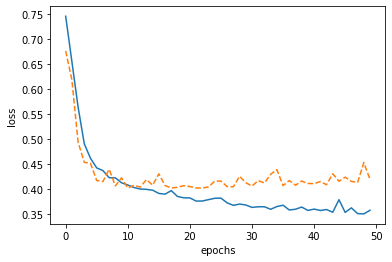

In [739]:
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(history_df['epoch'], history_df['loss'], label='Training')
plt.plot(history_df['epoch'], history_df['val_loss'], label='Validation', linestyle='dashed')

### Model Evaluation

In [740]:
lr_model.evaluate(X_val, Y_val)

48/48 [==============================] - 0s 4ms/step - loss: 0.3938 - binary_accuracy: 0.8293


[0.3938466012477875, 0.8292843103408813]

In [741]:
pred = lr_model.predict(X_val)
pred = pred > .5
pred =(pred[:,0]).astype(int)


In [742]:
tp = np.logical_and(pred == 1, Y_val == 1).sum()  # true positive
tn = np.logical_and(pred == 0, Y_val == 0).sum()  # true negative
fp = np.logical_and(pred == 1, Y_val == 0).sum()  # false positive
fn = np.logical_and(pred == 0, Y_val == 1).sum()  # false negative

precision = tp/(tp+fp)
recall = tp/(tp+fn)

f1_score = 2*(precision*recall)/(precision+recall)

print("True Positive: ", tp)
print("True Negative: ", tn)
print("False Positive: ", fp)
print("false Negative: ", fn)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)


True Positive:  559
True Negative:  704
False Positive:  110
false Negative:  150
Precision:  0.8355754857997011
Recall:  0.7884344146685472
F1 Score:  0.8113207547169812


In [743]:
def displayConfusionMatrix(y_test, pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test,
        pred,
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

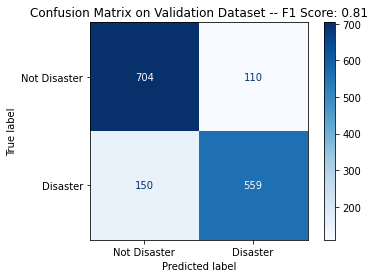

In [744]:
displayConfusionMatrix(Y_val, pred, "Validation")

### Inference

In [745]:
test_tokenized = tokenize(df_test["text"])
test_padded = pad_tokens(test_tokenized, max_len)
print("shape of test_padded: ", test_padded.shape)

shape of test_padded:  (3263, 157)


In [746]:
test_attention_mask = get_attention_mask(test_padded)
print("shape of test attention mask: ", test_attention_mask.shape)

shape of test attention mask:  (3263, 157)


In [747]:
test_input_ids = tf.convert_to_tensor(test_padded, dtype=tf.int32)
test_attention_mask = tf.convert_to_tensor(test_attention_mask, dtype=tf.int32)

In [748]:
test_features = get_features(test_input_ids, test_attention_mask, "data/E_test.npy")
print("shape of test_feature vectors: ", test_features.shape)

shape of test_feature vectors:  (3263, 768)


In [749]:
X_test = test_features
X_test = np.append(X_test, test_keyword[:split_size,:], axis=1)

In [750]:
pred_test = lr_model.predict(X_test)
pred_test = pred_test > .5
pred_test =(pred_test[:,0]).astype(int)

In [751]:
sample_submission = pd.read_csv("data/sample_submission.csv")
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [752]:
sample_submission["target"] = pred_test
sample_submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [753]:
sample_submission.describe()

,id,target
count,3263.000000,3263.000000
mean,5427.152927,0.413117
std,3146.427221,0.492469
min,0.000000,0.000000
25%,2683.000000,0.000000
50%,5500.000000,0.000000
75%,8176.000000,1.000000
max,10875.000000,1.000000


In [754]:
sample_submission.to_csv("data/submission2.csv", index=False)